## Tensorflow の学習済みモデルをNeoでコンパイルして推論に利用する
### 学習済みモデルのダウンロード
学習済みモデルがS3にアップロードされていれば、学習インスタンスで読み込んで、学習済みモデルから学習をスタートすることできます。
まずは、tensorflowのmobilenet_v1_0.25_128のモデルをダウンロード・解凍します。

In [ ]:
import urllib.request
import os

download_file = "mobilenet_v1_0.25_128.tgz"
if not os.path.exists(download_file):
    url ="http://download.tensorflow.org/models/mobilenet_v1_2018_02_22/mobilenet_v1_0.25_128.tgz"
    urllib.request.urlretrieve(url, download_file)
    
!tar xvzf $download_file

## データのダウンロード

### Validation dataのGround Truthのダウンロード

Tensorflowの学習済みモデルが出力するラベルIDは、ILSVR2012のサイトで確認できるものとは異なり、caffeモデルで採用されているラベルIDとなります、従って、Validation dataのGround TruthのIDを、caffeモデルを配布しているサイト(http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz) からダウンロードします。　Validation dataのGround Truthは、`./gt/val.txt`におかれます。

In [ ]:
!wget http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
!mkdir gt
!tar -xf caffe_ilsvrc12.tar.gz -C ./gt

### Validation dataの画像データのダウンロード

画像データはILSVRC 2012で配布されているもの(http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_val.tar) を利用します。非常に大きく、ダウンロードに数時間かかるため、適当なところで停止(■を押すなど)することができます。その場合は、ダウンロードできたところまで展開して、`./images`に保存されますが、最後の画像が破損する可能性がありますので削除してください（Last modifiedの新しいファイルが破損している可能性が高いです）

In [ ]:
!wget http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_val.tar
!tar -xf ILSVRC2012_img_val.tar
!mkdir images
!mv *.JPEG ./images

## 学習済みモデルのロード
学習済みモデルのロードの手順は以下のとおりです。
1. 入力のテンソルを定義します。
2. `mobilenet_v1.mobilenet_v1`を利用してモデルを定義します。`mobilenet_v1`はpythonファイルをダウンロードして使用します。
3. ckptファイルを読み込んで、学習済みのパラメータで初期化します。

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import tensorflow.contrib.slim as slim
from  tensorflow.contrib.slim import nets
import os
checkpoint_file = 'mobilenet_v1_0.25_128.ckpt'

# In order to use MobileNet v1, we expoloit mobilenet_v1.py in the official TF repo.
# This helps defining mobilenet network.
download_file = "mobilenet_v1.py"
if not os.path.exists(download_file):
    print('Download mobilenet_v1.py')
    url ="https://raw.githubusercontent.com/tensorflow/models/master/research/slim/nets/mobilenet_v1.py"
    urllib.request.urlretrieve(url, download_file)

# Initialize the network.
tf.reset_default_graph()

# Defining the network and load checkpoint
input_tensor = tf.placeholder(tf.float32, shape=(None,128,128,3), name='input_image')
sess = tf.Session()
import mobilenet_v1
with tf.contrib.slim.arg_scope(mobilenet_v1.mobilenet_v1_arg_scope()):
    logits, end_points = mobilenet_v1.mobilenet_v1(inputs=input_tensor, depth_multiplier=0.25, is_training=False, num_classes = 1001)
saver = tf.train.Saver()
saver.restore(sess, checkpoint_file)

画像を読み込んでテストしてみます。表示されるラベルは、ダウンロードしたGround Truthのラベルよりも1多いことに注意してください（Mobilenetでは背景IDが最初に追加されているためです）。

In [ ]:
def standardize_img(pil_image, height, width):
    image = pil_image.resize((height,width)).convert('RGB')
    image = (np.array(image)/255 - 0.5 )*2
    return image.reshape(-1, 128,128,3)

height, width = 128, 128
im = Image.open('images/ILSVRC2012_val_00001545.JPEG')
im = standardize_img(im, height, width)
prob = sess.run(end_points['Predictions'], feed_dict={input_tensor: im})
prob = prob.reshape(-1)

# top-5 labels (but not sorted)
ind = np.argpartition(prob, -5)[-5:]

# top-5 labels
# Taking negtive (-) yields descending order
sorted_class = ind[np.argsort(-prob[ind])]
print(sorted_class - 1) # The first class_id is background, which should be removed
print(prob[sorted_class])

## Tensorflow 用のモデルにexportしてS3にアップロード
NeoでコンパイルするモデルはS3にアップロードされている必要があります。
- `tf.saved_model.simple_save`を利用してモデルを保存し、model.tar.gzに圧縮します。
- SageMaker Python SDKを利用して、model.tar.gzをアップロードします。

In [ ]:
import os
import shutil

export_path = "./export"
if os.path.exists(export_path):
    shutil.rmtree(export_path)

tf.saved_model.simple_save(
    sess,
    os.path.join('export/Servo/1/'),
    inputs={'input_image': input_tensor},
    outputs={'output': end_points['Predictions']})

!tar -zcvf model.tar.gz export

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

bucket_name = sagemaker_session.default_bucket()
prefix_name  = 'pretrained_model/resnet_tf'
file_name = 'model.tar.gz'
model_file = sagemaker_session.upload_data(path=file_name, bucket=bucket_name, key_prefix=prefix_name)
print('Your pretrained model is uploaded to: {}'.format(model_file))

## モデルのデプロイ
ここでは、コンパイルしないモデルとコンパイルしたモデルの双方をデプロイしてみます。

### コンパイルしないモデルのデプロイ
`TensorFlowModel`に、先ほどアップロードしたS3のモデルのパス`model_file`を与えてモデルを読み込みます。entry pointとして`mobilenet_neo.py`を読み込んでいますが、コンパイル無しのモデルのみをデプロイする場合、特にエントリーポイントを利用しません。ただし、entry_pointは必須の引数なので任意のファイルを指定する必要があります。今回は、このentry pointを後のコンパイルしたモデル用に利用しますので、ここで指定しておき、あとの処理に引き継ぎます。モデルを読み込んだら`deploy`をします。

In [ ]:
from sagemaker import tensorflow
from datetime import datetime

tf_model = sagemaker.tensorflow.model.TensorFlowModel(model_data = model_file,
                                            entry_point ='mobilenet_neo.py', 
                                            py_version='py2',
                                            role = role,
                                            framework_version='1.11.0',
                                            sagemaker_session=sagemaker_session)
predictor = tf_model.deploy(initial_instance_count = 1,instance_type = 'ml.c5.xlarge')

### コンパイルしたモデルのデプロイ

モデルのコンパイルでは、`input_shape`に最初に定義した入力テンソルの名前とshapeを指定する必要があります。またoutput_pathも指定します。`compile`関数でモデルをコンパイルできます。コンパイルが終われば、モデル名やイメージ名を指定してデプロイします。

デプロイによって作成されたエンドポイントは、png形式で画像を受け取り、エントリーポイントでnumpy形式に変換されて推論をします。png形式で画像をうけとるための`png_serializer`を定義して設定します。

In [ ]:
from datetime import datetime
tf_compiled_model = tf_model.compile(target_instance_family='ml_c5', 
                                     input_shape={'input_image': [1,128,128,3]},
                                     output_path = 's3://'+sagemaker_session.default_bucket() + '/compiled-model/tf-mobilenet/',
                                     role = role,
                                     job_name ="tensorflow-resnet-neo-compile-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S"),
                                     framework='tensorflow',
                                     framework_version='1.11.0')
tf_compiled_model.name = "tensorflow-neo-compile-model-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
tf_compiled_model.image = '301217895009.dkr.ecr.us-west-2.amazonaws.com/sagemaker-neo-tensorflow:1.11.0-cpu-py3'
compiled_predictor = tf_compiled_model.deploy(initial_instance_count = 1,instance_type = 'ml.c5.xlarge')
import io
def png_serializer(data):
    im = Image.fromarray(data.reshape((128,128,3)))
    f = io.BytesIO()
    im.save(f, format='png')
    f.seek(0)
    return f.read()

compiled_predictor.content_type = 'application/x-image'
compiled_predictor.serializer = png_serializer

## コンパイルしていないモデルをElastic inferenceでデプロイ

TensorflowからElastic Inferenceを利用する場合には、SageMakerのモデルはTensorflow Serving形式である必要があります。

In [ ]:
from datetime import datetime

tf_model = sagemaker.tensorflow.serving.Model(model_data = model_file,
                                            role = role,
                                            framework_version='1.11.0',
                                            sagemaker_session=sagemaker_session)
tf_compiled_model.name = "tensorflow-eia-model-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
eia_predictor = tf_model.deploy(initial_instance_count = 1,instance_type = 'ml.c5.xlarge', accelerator_type='ml.eia1.medium')

## 推論性能の比較

### 推論時間の比較
`./images`にある画像から10枚の画像をランダムに抽出して、以下の３種類のエンドポイントで推論します。

- コンパイルしていないモデル 
- コンパイルしたモデル
- コンパイルしていないモデルとElastic Inference

In [ ]:
!pip install tqdm

In [135]:
import time
from tqdm import tqdm_notebook as tqdm

image_files = os.listdir("./images")
index = np.random.choice(len(image_files), 100, replace=False)
image_files = [image_files[i] for i in range(len(image_files)) if i in index]

baseline_time = 0
compile_time = 0
eia_time = 0
print("Evaluating three endopoints with 100 images.")
for f in tqdm(image_files):
    pil_img = Image.open('images/'+f)

    #Preprocess for base model
    image = pil_img.resize((128,128)).convert('RGB')
    image = (np.array(image)/255 - 0.5 )*2
    im =  image.reshape(-1, 128,128,3)

    #Inference by base model
    start = time.time()
    result = predictor.predict({'input_image':im})
    baseline_time += time.time()-start

    #Preprocess for compiled  model
    im = np.array(pil_img.resize((128,128)).convert('RGB'))
    
    #Inference by compiled model
    start = time.time()
    predict_response = compiled_predictor.predict(im)
    compile_time += time.time()-start

    #Preprocess for model with EI
    image = pil_img.resize((128,128)).convert('RGB')
    image = (np.array(image)/255 - 0.5 )*2
    im =  image.reshape(128,128,3)
    
    #Inference by model with EI
    start = time.time()
    predict_response = eia_predictor.predict({'input_image':im})
    eia_time += time.time()-start

Evaluating three endopoints with 100 images.


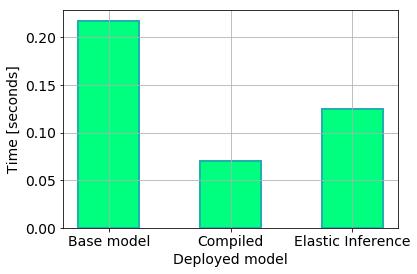

,Time [seconds]
Base model,0.217402
Compiled,0.070540
Elastic Inference,0.124918


In [136]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

left = np.array([1, 2, 3])
height = np.array([baseline_time/100.0,  compile_time/100.0, eia_time/100.0])
label = ["Base model", "Compiled", "Elastic Inference"]
plt.bar(left, height, tick_label=label, width=0.5,linewidth=2, color="#00FF7F", edgecolor="#20B2AA")

plt.ylabel("Time [seconds]")
plt.xlabel("Deployed model")
plt.grid()

plt.show()

df = pd.DataFrame(height, index = label, columns=['Time [seconds]'])
display(df)

### メモリ使用量の比較

boto3 を利用してCloudWatchのメトリクスを見てみます。

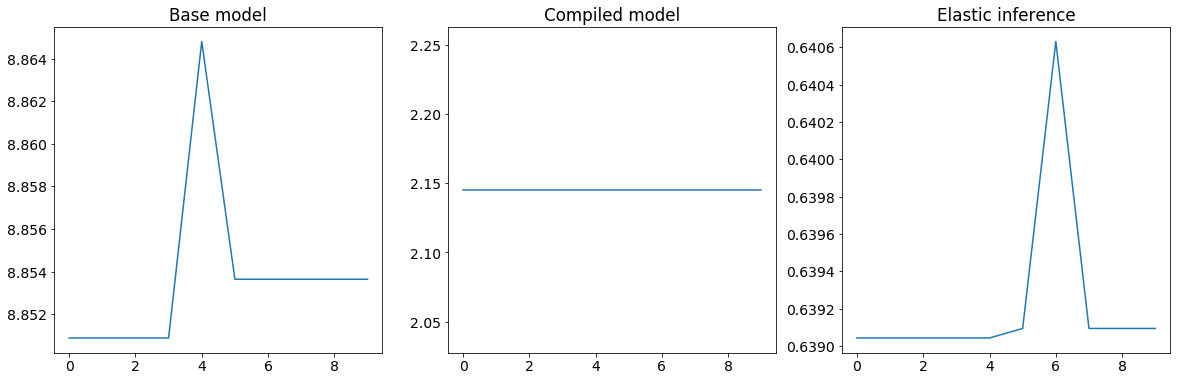

In [137]:
%matplotlib inline
import boto3
from boto3.session import Session
import datetime

import boto3

client = boto3.client('cloudwatch')

response = client.get_metric_data(
    MetricDataQueries=[
        {
            'Id': 'base',
            'MetricStat': {
                'Metric': {
                    'Namespace': '/aws/sagemaker/Endpoints',
                    'MetricName': 'MemoryUtilization',
                    'Dimensions': [
                        {
                            'Name': 'EndpointName',
                            'Value': predictor.endpoint
                        },
                        {
                            'Name': 'VariantName',
                            'Value': 'AllTraffic',
                        },
                    ]
                },
                'Period': 1,
                'Stat': 'Average',
            },
            'ReturnData': True
        },
        {
            'Id': 'compiled',
            'MetricStat': {
                'Metric': {
                    'Namespace': '/aws/sagemaker/Endpoints',
                    'MetricName': 'MemoryUtilization',
                    'Dimensions': [
                        {
                            'Name': 'EndpointName',
                            'Value': compiled_predictor.endpoint
                        },
                        {
                            'Name': 'VariantName',
                            'Value': 'AllTraffic',
                        },
                    ]
                },
                'Period': 1,
                'Stat': 'Average',
            },
            'ReturnData': True
        },
        {
            'Id': 'compiledei',
            'MetricStat': {
                'Metric': {
                    'Namespace': '/aws/sagemaker/Endpoints',
                    'MetricName': 'MemoryUtilization',
                    'Dimensions': [
                        {
                            'Name': 'EndpointName',
                            'Value': eia_predictor.endpoint
                        },
                        {
                            'Name': 'VariantName',
                            'Value': 'AllTraffic',
                        },
                    ]
                },
                'Period': 1,
                'Stat': 'Average',
            },
            'ReturnData': True
        },
    ],
    StartTime=datetime.datetime.utcnow() - datetime.timedelta(seconds=1200),
    EndTime=datetime.datetime.utcnow(),
    ScanBy='TimestampAscending',
    MaxDatapoints=20000
)

results = response['MetricDataResults']
for r in results:
    if r['Id'] == 'base':
        base_memory = r['Values'][:10]
    elif r['Id'] == 'compiled':
        compiled_memory = r['Values'][:10]
    elif r['Id'] == 'compiledei':
        compiled_ei_memory = r['Values'][:10]

x_label  = range(10)
fig = plt.figure(figsize=(20,6))
plt.rcParams["font.size"] = 14
ax1 = fig.add_subplot(1, 3, 1)
plt.title(r"Base model")
ax1.plot(x_label, base_memory)
ax2 = fig.add_subplot(1, 3, 2)
plt.title(r"Compiled model")
ax2.plot(x_label, compiled_memory)
ax3 = fig.add_subplot(1, 3, 3)
plt.title(r"Elastic inference")
ax3.plot(x_label, compiled_ei_memory)
plt.show()
fig.clf()